In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helperClasses.DataPipeline import DataPipeline

In [65]:
df_cam = pd.read_csv("../Dataframe/df_detected_objects_game.csv", )
df_labels = pd.read_csv("../Dataframe/tennis_labels.csv", sep=";")
#Spalten ohne Werte entfernen
df_cam = df_cam.drop(columns= ["head_x", "head_y", "head_z"], axis=1)

In [66]:
df_cam["object_id"] = df_cam["object_id"].astype("category")
df_cam["object_label"] = df_cam["object_label"].astype("category")
df_cam["tracking_state"] = df_cam["tracking_state"].astype("category")

In [67]:
df_cam.shape

(42571, 14)

## Hilfe Funktionen

Um neue Spalten zu erstellen oder die Koordiante der Kamera auf das Tennisfeld zu projizieren, brauchen wir eine Funktion, die uns die Koordinaten der Kamera auf das Tennisfeld projiziert.

In [68]:
def Tennisfeld(r, P1, P2, P3):
    r1 = P2 - P1
    r3 = P3 - 0.5*(P1 + P2)
    # Basisvektoren
    r1u = r1 / np.sqrt(np.dot(r1, r1))
    r3u = r3 / np.sqrt(np.dot(r3, r3))
    r2u = np.cross(r1u, r3u)
    # Translation
    T0 = P3
    # Rotation
    M1 = np.c_[r1u, r2u, r3u]
    M1_inv = np.linalg.inv(M1)
    # Abbildung
    return np.inner(M1_inv, (r - T0))


In [69]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.40, 6.40], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

# Datawrangling

## Kamera Dataframe

### Koordinaten der Kamera auf das Tennisfeld projizieren

In [70]:
# Kooridnaten auf dem Tennisfeld als Kalibrierung
P1=np.array([-4.207, -1.846, 5.733]) # Linke Ecke an der Grundlinie
P2=np.array([3.415, -1.870, 5.489]) # Rechte Ecke an der Grundlinie
P3=np.array([-0.057, -1.703, 15.554])   # Mittelpunkt am Netz

In [71]:
df_cam["z"] = df_cam["z"].apply(abs)

Weil die Kamera die Z-Achse negativ ausgibt und die Basistransformation nur positive Werte erwartet, drehen wir die Z-Achse um.

In [72]:
df_cam[['new_x', 'new_y', 'new_z']] = df_cam.apply(lambda row: pd.Series(Tennisfeld(np.array([row['x'], row['y'], row['z']]), P1, P2, P3)), axis=1)
df_cam.drop(columns=["x", "y", "z"], inplace=True)

### Visualisierung auf dem Tennisfeld

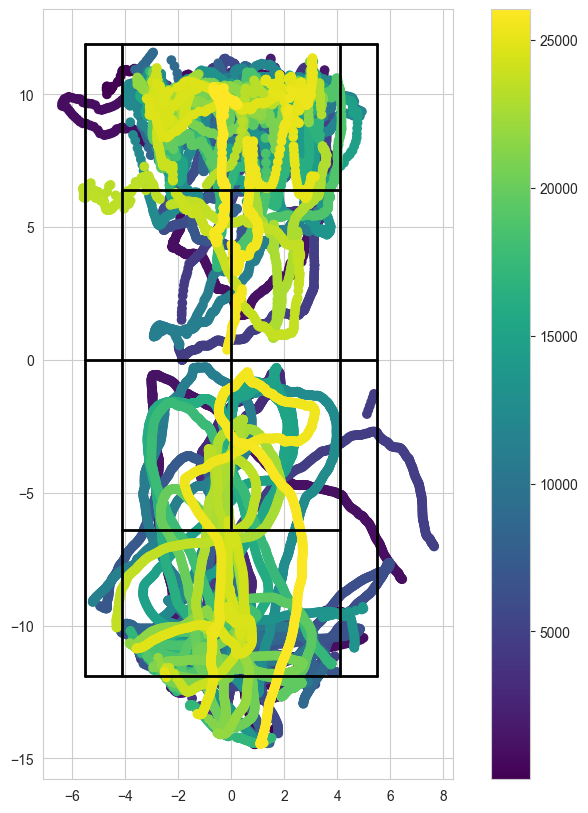

In [73]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Wir sehen, dass die Kamera den ersten Spieler sehr gut erkennt, aber der zweite Spieler scheint etwas zu weit vorne zu stehen. 
Wir geben dem zweiten Spieler einen Offset von 2m nach hinten.

Um den Daten aber einen Offset zu geben, beheben wir noch ein anderes Problem. Die Objekte haben viele verschiedene IDs, wir werden diese anhand der Koordianten anpassen.

In [74]:
df_cam["object_id"] = np.where(df_cam["new_z"] < 0, "Player1", "Player2")

### Offset

In [75]:
df_cam.loc[df_cam["object_id"] == "Player2", "new_z"] = df_cam.loc[df_cam["object_id"] == "Player2", "new_z"] + 2

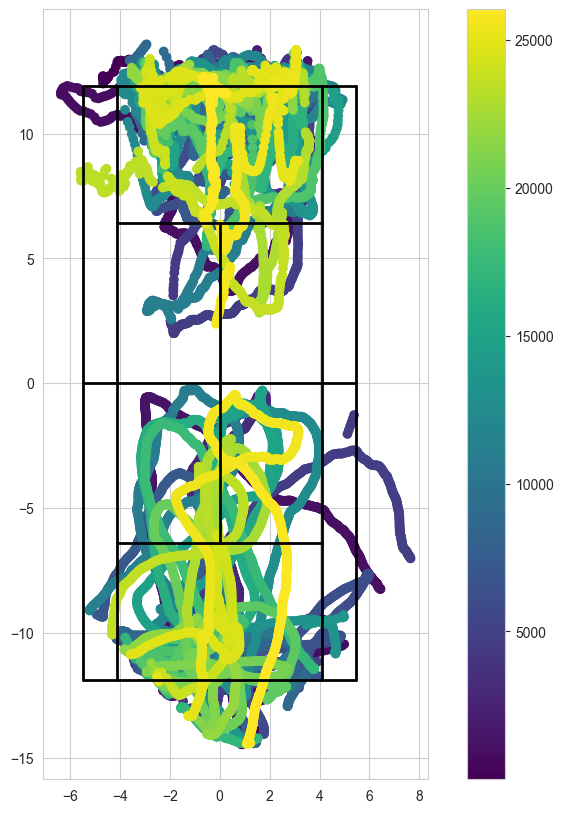

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Das Ergebnis sieht nun besser aus, obwohl die bewegung des zweiten Spielers etwas komisch aussieht.
Das liegt wahrscheinlich daran, dass die Kamera auf weitere Entfernung nicht mehr so genau ist.

### Doppelte Frames

Die Kamera gibt die Position für beide Spieler in einer seperaten Zeile aus. Da sie aber im geleichen Frame aufgenommen wurden, können wir diese zusammenführen.

Um Fehler auszuschliessen schneiden wir die Daten anhand der Labels, da wir Start und Endzeitpunkt kennen.

In [77]:
max_label = df_labels["Frame"].max()
min_label = df_labels["Frame"].min()

In [78]:
df_cam = df_cam[ (df_cam["frame"] >= min_label) & (df_cam["frame"] <= max_label)]

In [79]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
22210,13586,Player2,Person,82.42188,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22212,13587,Player2,Person,87.59766,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22214,13588,Player2,Person,87.59766,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22216,13589,Player2,Person,89.59961,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22218,13590,Player2,Person,89.50195,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22220,13591,Player2,Person,90.38086,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


Die Daten lassens sich aber nicht einfach zum andere Format umwandeln. Das Problem liegt an den vergebenen IDs. Die Kamera vergibt immer neue IDs, wenn ein Objekt nicht mehr erkannt wird. Wir umgehen dass, in dem wir sagen positive z-Koordiante rist Player 2 und negative Player 1. Da die Kamera aber etwas ungenau ist am Netz vorne müssen wir die Daten anpassen.

In [80]:
len(df_cam[df_cam.duplicated(subset=["frame", "object_id"], keep=False)])

68

Glücklicherweise kommt es nur 68 mal vor also entfernen wir diese Frames

In [81]:
df_cam = df_cam.drop_duplicates(subset=["frame", "object_id"], keep=False)

In [82]:
df_cam

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
521,287,Player1,Person,83.69141,OK,0.01540,-0.04420,0.15406,0.64888,1.99435,0.64888,0.488342,-1.157367,-9.915421
522,287,Player2,Person,32.34863,OK,-0.06328,0.04720,-0.17333,0.61570,1.17692,0.61570,-2.556822,5.167203,11.479640
523,288,Player1,Person,87.69531,OK,0.02580,-0.03045,0.10899,0.66799,1.97376,0.66799,0.487970,-1.155410,-9.916995
524,288,Player2,Person,33.88672,OK,-0.05046,0.03763,-0.13822,0.61899,1.17656,0.61899,-2.551163,5.141961,11.366557
525,289,Player1,Person,87.45117,OK,0.02339,-0.02760,0.09879,0.68904,1.95456,0.68904,0.487290,-1.155982,-9.917908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41443,25418,Player2,Person,53.32031,OK,0.35546,-0.14441,0.56125,0.61038,1.38896,0.61039,0.834903,4.535234,10.239158
41444,25419,Player1,Person,75.58594,OK,1.42219,-0.00269,0.27825,0.71328,1.65808,0.71328,1.689395,0.776300,-2.944103
41445,25419,Player2,Person,54.58984,OK,0.26817,-0.08407,0.33846,0.60976,1.39458,0.60976,0.832179,4.524261,10.182033
41446,25420,Player1,Person,74.56055,OK,1.36259,0.00797,0.23094,0.68662,1.65815,0.68662,1.714517,0.774839,-2.944206


### Duplikate

Vorhin haben wir schon nach Duplikate gesucht, aber nur nach Frames und IDs. Wir betrachten nun die Koordinaten.

In [83]:
df_cam[df_cam.duplicated()]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z


Glücklicherweise gibt es keine Duplikate.

## NaN Werte

In [84]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z


In [85]:
df_cam_wrangled = df_cam.dropna()

Die Spalten müssen leider entfernen werden auch wenn sehr viele sind.

## Label Dataframe

In [86]:
df_labels.head()

,Frame,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
0,287,Aktiv,Anschlag,NaN,1.0
1,318,NaN,NaN,Fronthand,NaN
2,372,NaN,Fronthand,NaN,NaN
3,421,NaN,NaN,Backhand,NaN
4,469,NaN,Backhand,NaN,NaN


Da das gelabelte Dataframe erzeugt wurde, gehen wir von keinen Fehlern aus

## Merge der beiden Dataframes

In [94]:
df_cam_pivot = pd.pivot(df_cam_wrangled, index="frame", columns="object_id", values=["new_x", "new_y", "new_z", 'vx', 'xy', 'vz', 'width', 'height', 'length'])
#Collapse the MultiIndex
df_cam_pivot.columns = df_cam_pivot.columns.map('_'.join).str.strip()
#Reset Index to get the Name column back
df_cam_pivot = df_cam_pivot.reset_index()

In [95]:
df_cam_pivot.head()

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,vx_Player1,vx_Player2,xy_Player1,xy_Player2,vz_Player1,vz_Player2,width_Player1,width_Player2,height_Player1,height_Player2,length_Player1,length_Player2
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,11.479640,0.01540,-0.06328,-0.04420,0.04720,0.15406,-0.17333,0.64888,0.61570,1.99435,1.17692,0.64888,0.61570
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,11.366557,0.02580,-0.05046,-0.03045,0.03763,0.10899,-0.13822,0.66799,0.61899,1.97376,1.17656,0.66799,0.61899
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,11.280055,0.02339,-0.06145,-0.02760,0.04583,0.09879,-0.16830,0.68904,0.62047,1.95456,1.17893,0.68904,0.62047
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,11.270463,0.02728,-0.04928,-0.03218,0.03674,0.11523,-0.13497,0.71109,0.62504,1.95276,1.18399,0.71109,0.62504
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,11.268751,0.01641,-0.04386,-0.01936,0.03270,0.06932,-0.12013,0.73265,0.62681,1.94945,1.17943,0.73265,0.62681


In [97]:
df = pd.merge(df_cam_pivot, df_labels, left_on="frame", right_on="Frame", how="left")
df = df.drop(columns=["Frame"])

In [98]:
df[["Status", "Satz"]] = df[["Status", "Satz"]].ffill()

In [99]:
df.head()

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,vx_Player1,vx_Player2,xy_Player1,...,width_Player1,width_Player2,height_Player1,height_Player2,length_Player1,length_Player2,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,11.479640,0.01540,-0.06328,-0.04420,...,0.64888,0.61570,1.99435,1.17692,0.64888,0.61570,Aktiv,Anschlag,NaN,1.0
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,11.366557,0.02580,-0.05046,-0.03045,...,0.66799,0.61899,1.97376,1.17656,0.66799,0.61899,Aktiv,NaN,NaN,1.0
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,11.280055,0.02339,-0.06145,-0.02760,...,0.68904,0.62047,1.95456,1.17893,0.68904,0.62047,Aktiv,NaN,NaN,1.0
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,11.270463,0.02728,-0.04928,-0.03218,...,0.71109,0.62504,1.95276,1.18399,0.71109,0.62504,Aktiv,NaN,NaN,1.0
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,11.268751,0.01641,-0.04386,-0.01936,...,0.73265,0.62681,1.94945,1.17943,0.73265,0.62681,Aktiv,NaN,NaN,1.0


- object_id scheint zu viele unterschiedliche labels zu haben.
- confidence scheint muss noch genauer untersucht werden, da die Werte teilweise etwas tief sind

## Explorative Datenanalyse

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23975 entries, 0 to 23974
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frame             23975 non-null  int64  
 1   new_x_Player1     21944 non-null  float64
 2   new_x_Player2     18915 non-null  float64
 3   new_y_Player1     21944 non-null  float64
 4   new_y_Player2     18915 non-null  float64
 5   new_z_Player1     21944 non-null  float64
 6   new_z_Player2     18915 non-null  float64
 7   vx_Player1        21944 non-null  float64
 8   vx_Player2        18915 non-null  float64
 9   xy_Player1        21944 non-null  float64
 10  xy_Player2        18915 non-null  float64
 11  vz_Player1        21944 non-null  float64
 12  vz_Player2        18915 non-null  float64
 13  width_Player1     21944 non-null  float64
 14  width_Player2     18915 non-null  float64
 15  height_Player1    21944 non-null  float64
 16  height_Player2    18915 non-null  float6